In [23]:
# libraries
import numpy as np
import pandas as pd
import os
import re

from operator import truediv
from matplotlib.pyplot import figure
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
import matplotlib.pyplot as plt
%matplotlib inline


def extract_current(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[0])

def extract_avg(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[1])

def Read(workload, folder = "."):
    wa = [1,2,3,4]
    wip   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    peb   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    rocks = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    level = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    
    bucket = []
    with open(folder + "/kv_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("2019/0"):
                data = line.strip().split()
                data = [data[i] for i in (0,3,4,7)]
                wip.loc[len(wip)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[0] = float(data[1])
            if line.startswith("Bucket"):
                data = line.split() #split string into a list
                bucket.append(int(data[1]))
                
    with open(folder + "/peb_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("2019/0"):
                data = line.strip().split()
                data = [data[i] for i in (0,3,4,7)]
                peb.loc[len(peb)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[1] = float(data[1])
                
    with open(folder + "/rocks_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("2019/0"):
                data = line.strip().split()
                data = [data[i] for i in (0,3,4,7)]
                rocks.loc[len(rocks)] = data
            if line.startswith(" Sum"): 
                data = line.split() #split string into a list
                wa[2] = float(data[11])
                
    with open(folder + "/level_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("2019/0"):
                data = line.strip().split()
                data = [data[i] for i in (0,3,4,7)]
                level.loc[len(level)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[3] = float(data[1])
                
    df = pd.DataFrame(columns = []) 
    
    df['WipDB']       = wip['speed'].apply(extract_current)
    df['WipDB_write'] = wip[wip['thread']=="0:"]['speed'].apply(extract_current)
    df['WipDB_read1']  = wip[wip['thread']=="1:"]['speed'].apply(extract_current)
    df['WipDB_read2']  = wip[wip['thread']=="2:"]['speed'].apply(extract_current)
    df['WipDB_read3']  = wip[wip['thread']=="3:"]['speed'].apply(extract_current)
    
    
    df['PebblesDB']       = peb['speed'].apply(extract_current)
    df['PebblesDB_write'] = peb[peb['thread']=="0:"]['speed'].apply(extract_current)
    df['PebblesDB_read1']  = peb[peb['thread']=="1:"]['speed'].apply(extract_current)
    df['PebblesDB_read2']  = peb[peb['thread']=="2:"]['speed'].apply(extract_current)
    df['PebblesDB_read3']  = peb[peb['thread']=="3:"]['speed'].apply(extract_current)
    
    
    df['RocksDB']       = rocks['speed'].apply(extract_current)
    df['RocksDB_write'] = rocks[rocks['thread']=="0:"]['speed'].apply(extract_current)
    df['RocksDB_read1']  = rocks[rocks['thread']=="1:"]['speed'].apply(extract_current)
    df['RocksDB_read2']  = rocks[rocks['thread']=="2:"]['speed'].apply(extract_current)
    df['RocksDB_read3']  = rocks[rocks['thread']=="3:"]['speed'].apply(extract_current)
    
    
    df['LevelDB']       = level['speed'].apply(extract_current)
    df['LevelDB_write'] = level[level['thread']=="0:"]['speed'].apply(extract_current)
    df['LevelDB_read1']  = level[level['thread']=="1:"]['speed'].apply(extract_current)
    df['LevelDB_read2']  = level[level['thread']=="2:"]['speed'].apply(extract_current)
    df['LevelDB_read3']  = level[level['thread']=="3:"]['speed'].apply(extract_current)
    
    df = df / 1000.0
    
    df["Bucket"] = 0
#     print(bucket)
    start = 0
    for i in df[df['WipDB_write'].notnull()].index.values:
#         print(i, bucket[start])
        df['Bucket'][i] = bucket[start]
        start = start + 1
    
    for i in range(len(df)):
        if df['Bucket'][i] == 0 and i != 0:
            df['Bucket'][i] = df['Bucket'][i-1]
            
    min_bucket = 2000
    for i in range(len(df)):
        if df['Bucket'][i] != 0:
            min_bucket = min(min_bucket, df['Bucket'][i])
            
    for i in range(len(df)):
        if df['Bucket'][i] == 0:
            df['Bucket'][i] = min_bucket
            
    df.to_csv("test.csv")
    return df, wa

def Plot(df, wa, ax, ylim=20, m_title="123", m_alpha=0.1):
    words = ['WipDB', 'PebblesDB', 'RocksDB', 'LevelDB']
    for i in range(len(words)):        
        wdf = df[df[words[i] + '_write'].notnull()][words[i] + '_write']
        # plot write
        wdf.plot(ax=ax[i], fontsize=16, color='darkgreen', markevery=1, markersize=3,  alpha=0.9)
        
        # print db name
        ax[i].text(len(df) - len(df)*0.15, 10, words[i], horizontalalignment='center', fontsize=18)
        ax[i].tick_params(axis='y', colors='darkgreen', pad=-3)
        
        # print wa
#         ax[i].text(len(df) - len(df)*0.15, 155, "WA:" + ("%.1f" % (wa[i],)), horizontalalignment='center', fontsize=18)
        
        # plot read
        ax0t = ax[i].twinx()
        df[df[words[i] + '_read1'].notnull()][words[i] + '_read1'].plot(ax=ax0t, fontsize=16, color='b', dashes=[4, 2], markersize=3,  alpha=0.8)
        df[df[words[i] + '_read2'].notnull()][words[i] + '_read2'].plot(ax=ax0t, fontsize=16, color='b', dashes=[4, 2], markersize=3,  alpha=0.8)
        df[df[words[i] + '_read3'].notnull()][words[i] + '_read3'].plot(ax=ax0t, fontsize=16, color='b', dashes=[4, 2], markersize=3,  alpha=0.8)
        ax0t.set_ylim([0,ylim])
        ax0t.tick_params(axis='y', colors='b', pad=-6, labelrotation=-90, labelsize=12)


        if (i == 0):
            # plot bucket number
            ax_bar = ax[i].twinx()
            df["Bucket"].plot.bar(ax=ax_bar, alpha=m_alpha, color='grey', edgecolor='grey')
            ax_bar.set_zorder(ax[i].get_zorder()+1) # set ax_bar behind ax[i]
            ax_bar.set_xticks([])
            ax_bar.set_yticks([])
            ax[i].legend(["Write"] , fontsize=18, frameon=False, bbox_to_anchor=(0., 0.85, 0.5, .1), loc='lower left')
            ax0t.legend(["Read"], fontsize=18, frameon=False, bbox_to_anchor=(0.5, 0.85, 0.5, .1), loc='lower right')
            ax_bar.text(len(df), df["Bucket"].max() - 20, df["Bucket"].max())
            
        ax[i].set_ylim([0,190])
        ax[i].grid(axis='y', linestyle='--')
        
        if i == 3:
            ax[i].text(len(df)*0.35, -35, m_title, fontsize=18)
    
#     result = pd.DataFrame(columns = ["a"])
#     result.loc['WipDB'] = wa[0]
#     result.loc['PebblesDB'] = wa[1]
#     result.loc['RocksDB'] = wa[2]
#     result.loc['LevelDB'] = wa[3]
#     result = result.T
    
#     ax_bar.yaxis.tick_right()
#     ax_bar.set_title("Write Amplification", fontsize=16, pad=10)
#     ax_bar.set_ylim([0, 45])
#     result.plot(ax=ax_bar, kind="bar", fontsize=20, rot=0, colormap='Accent', width=0.75, edgecolor='k')
#     bars = ax_bar.patches
#     hatches = ''.join(h*len(result) for h in 'O *x')
#     for bar, hatch in zip(bars, hatches):
#         bar.set_hatch(hatch)
#     ax_bar.legend(prop={'size': 12})
#     ax_bar.grid(axis='y', linestyle='--')
#     ax_bar.set_axisbelow(True)
#     ax_bar.set_xticks([])
    


/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWar

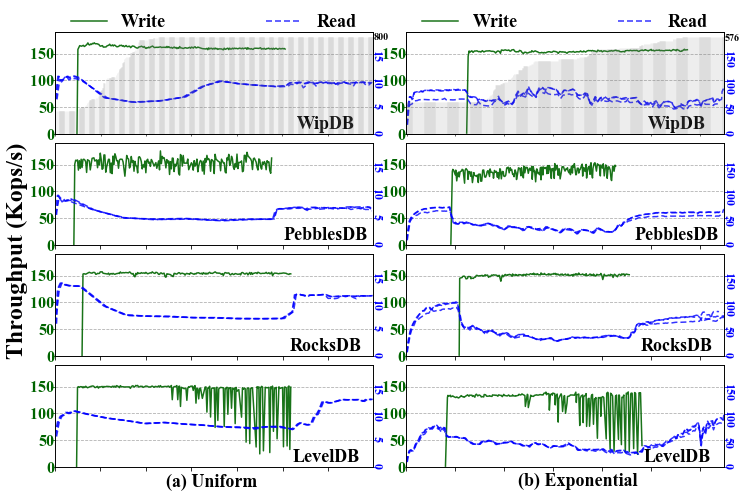

In [24]:
fig = plt.figure(figsize=(12, 8)) 
gs = gridspec.GridSpec(8, 20) 
gs.update(wspace=20, hspace=0.2) # set the spacing between axes. 
ax = [1,2,3,4]

df, wa = Read("readexpwhilewriting", "exp3")
ax[0] = plt.subplot(gs[:2,  10:])
ax[1] = plt.subplot(gs[2:4, 10:])
ax[2] = plt.subplot(gs[4:6, 10:])
ax[3] = plt.subplot(gs[6:8, 10:])

# ax_bar = plt.subplot(gs[:, 8:11])
Plot(df, wa, ax, 191, "(b) Exponential", 0.07)

df, wa = Read("readuniwhilewriting", ".")
ax[0] = plt.subplot(gs[:2, 0:10])
ax[1] = plt.subplot(gs[2:4, 0:10])
ax[2] = plt.subplot(gs[4:6, 0:10])
ax[3] = plt.subplot(gs[6:8, 0:10])
# ax_bar = plt.subplot(gs[:,  19:])
Plot(df, wa, ax, 19, "(a) Uniform")

fig.text(0.07, 0.5, 'Throughput (Kops/s)', va='center', rotation='vertical', fontsize=24)
fig.tight_layout()
plt.savefig('readwhilewriting_exp.pdf', bbox_inches='tight')

/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


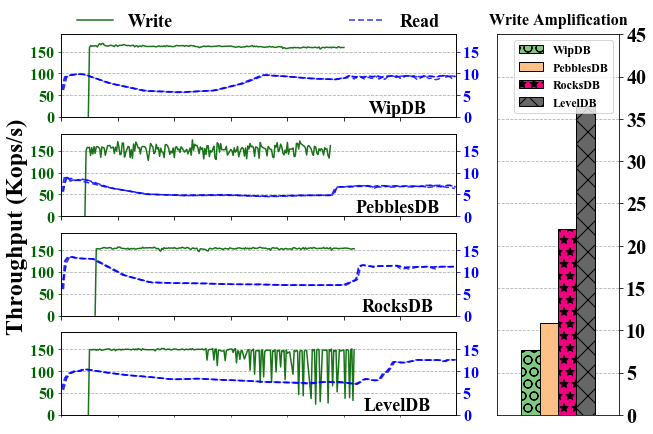

In [47]:
df, wa = Read("readuniwhilewriting", ".")
fig = plt.figure(figsize=(10, 7)) 
gs = gridspec.GridSpec(8, 11) 
gs.update(wspace=3, hspace=0.5) # set the spacing between axes. 

ax = [1,2,3,4]
split_pos = 8
ax[0] = plt.subplot(gs[:2, 0:split_pos])
ax[1] = plt.subplot(gs[2:4, 0:split_pos])
ax[2] = plt.subplot(gs[4:6, 0:split_pos])
ax[3] = plt.subplot(gs[6:8, 0:split_pos])

ax_bar = plt.subplot(gs[:, split_pos:])

Plot(df, wa, ax, 19)

plt.xticks([])
plt.savefig('readwhilewriting_full.pdf', bbox_inches='tight')

In [7]:
def WA(T):
    a = T*T *(T+1.0)/(T-1.0) * 4.95 + 3 * (T-1) *T *T +2*T*T +T
    b = T*T +T*T*(T-1) + T*T + T
    return a/b

print(WA(8))

3.231702544031311


In [8]:
def WA2(T):
    a = 4*T*T*T*T + 3 *T*T*T + 2*T*T +T
    b = T*T*T*T + T*T*T + T*T + T
    return a/b

print(WA2(8))

3.858119658119658
